# 引入包

In [1]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  numpy
import random
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import  Dataset,random_split,DataLoader
from numpy import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# 超参数

In [2]:
batch_size = 316
lr = 0.001
epoch_num = 20

# 加载数据集合

In [3]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):

        self.data_path = data_path
        self.transform = transform
        self.label_folder = os.listdir(self.data_path)
        self.file = []
        for str in self.label_folder:
            st = os.path.join(self.data_path, str)
            my = os.listdir(st)
            random.shuffle(my)
            t = my[int(len(my) * 0.7):]
            if train:
                t = my[:int(len(my) * 0.7)]

            for index in t:
                self.file.append(os.path.join(st, index))

    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):

        # 读取图像和标签文件
        image = Image.open(self.file[idx])
        label = os.path.split(os.path.dirname(self.file[idx]))[-1]
        # 数据转换
        if self.transform:
            image = self.transform(image)

        return image, torch.eye(3)[self.label_folder.index(label)]


transform = transforms.Compose([
    transforms.Resize((70, 70)),

    transforms.ToTensor(),
])

# 创建自定义数据集
TrainDataset = MyDataset(data_path=r'/kaggle/input/expersion03/train',
                         transform=transform
                         , train=True)
TestDataset = MyDataset(data_path=r'/kaggle/input/expersion03/train',
                        transform=transform
                        , train=False)
print(TrainDataset.__len__(), TestDataset.__len__())

948 409


# 定义卷积结构

In [4]:
def corr2d(X, K):
    batch_size, H, W = X.shape
    k_h, k_w = K.shape
    # 初始化结果矩阵
    Y = torch.zeros((batch_size, H - k_h + 1, W - k_w + 1)).to(device)
    for i in range(Y.shape[1]):
        for j in range(Y.shape[2]):
            Y[:, i, j] = (X[:, i:i + k_h, j:j + k_w] * K).sum()
    return Y


def corr2d_multi_in(X, K):
    res = corr2d(X[:, 0, :, :], K[0, :, :])
    for i in range(1, X.shape[1]):
        res += corr2d(X[:, i, :, :], K[i, :, :])
    return res


def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=1)


class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        kernel_size = (kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size))
        self.bias = nn.Parameter(torch.randn(self.out_channels, 1, 1))

    def forward(self, input_data):
        # 对输入数据进行填充
        input_data = torch.nn.functional.pad(input_data, (self.padding, self.padding, self.padding, self.padding))

        return corr2d_multi_in_out(input_data, self.weight) + self.bias

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            Conv2d(3, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 3)
        )
        # self.fc = nn.Linear(2048, 3)

    def forward(self, x):
        out = self.conv(x)
        out = nn.functional.avg_pool2d(out, 30)

        out = out.squeeze()
        out = self.fc(out.view(batch_size, -1))
        out = F.softmax(out, dim=1)
        return out

# 训练与超参数

In [6]:
import time

net = Net().to(device)
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
opt = torch.optim.Adam(net.parameters(), lr=lr)
train_loader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False)
loss = nn.CrossEntropyLoss()
start_time = time.time()
for epoch in range(epoch_num):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for x, y in train_loader:
        # print(y.shape)
        # plt.imshow(x[1].permute(1, 2, 0))  # 注意要将通道维度调整为最后一个维度
        # plt.axis('off')
        # plt.show()
        opt.zero_grad()
        y_hat = net(x.to(device))
        l = loss(y_hat.view(-1), y.view(-1).to(device))
        l.backward()
        opt.step()
        # print(l)
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        train_acc_list.append(acc/len(y_index))


        train_loss_list.append(l.item())

        # print("done")
    for x, y in test_loader:
        # print(y.shape)
        # plt.imshow(x[1].permute(1, 2, 0))  # 注意要将通道维度调整为最后一个维度
        # plt.axis('off')
        # plt.show()
        if(x.size()[0]<batch_size):
            continue
        y_hat = net(x.to(device))

        l = loss(y_hat.view(-1), y.view(-1).to(device))
        # print(l)
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        test_acc_list.append(acc/len(y_index))
        test_loss_list.append(l.item())
        # print("done")
    train_loss_mean = numpy.mean(train_loss_list)
    train_acc_mean=numpy.mean(train_acc_list)
    train_loss.append(train_loss_mean)
    train_acc.append(train_acc_mean)
    test_loss_mean=numpy.mean(test_loss_list)
    test_acc_mean=numpy.mean(test_acc_list)

    test_loss.append(test_loss_mean)
    test_acc.append(test_acc_mean)
    print("epoch:",epoch+1,"train_loss:",train_loss_mean,'train_acc',train_acc_mean

    ,"test_loss:", test_loss_mean, 'test_acc',test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 train_loss: 2150.82275390625 train_acc 0.4261603375527427 test_loss: 2158.39794921875 test_acc 0.4462025316455696
epoch: 2 train_loss: 2128.327880859375 train_acc 0.5748945147679324 test_loss: 2167.019287109375 test_acc 0.4462025316455696
epoch: 3 train_loss: 2127.2745768229165 train_acc 0.5748945147679326 test_loss: 2167.95458984375 test_acc 0.4462025316455696
epoch: 4 train_loss: 2127.393798828125 train_acc 0.5748945147679324 test_loss: 2168.052490234375 test_acc 0.4462025316455696
epoch: 5 train_loss: 2127.4025065104165 train_acc 0.5748945147679324 test_loss: 2168.066650390625 test_acc 0.4462025316455696
epoch: 6 train_loss: 2127.4037272135415 train_acc 0.5748945147679326 test_loss: 2168.069580078125 test_acc 0.4462025316455696
epoch: 7 train_loss: 2127.4042154947915 train_acc 0.5748945147679324 test_loss: 2168.07080078125 test_acc 0.4462025316455696
epoch: 8 train_loss: 2127.4043782552085 train_acc 0.5748945147679325 test_loss: 2168.071044921875 test_acc 0.4462025316455696

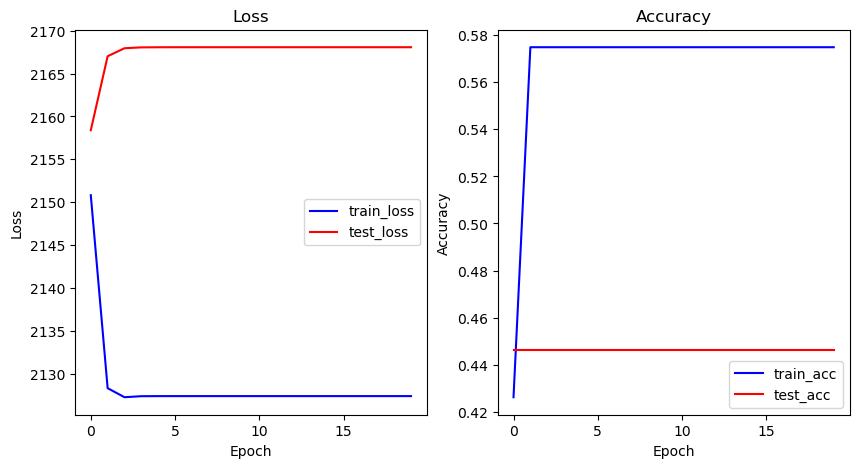

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(range(len(train_loss)),train_loss, 'b-',label="train_loss")
plt.plot(range(len(train_loss)),test_loss, 'r-' ,label="test_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)),train_acc, 'b-',label="train_acc")
plt.plot(range(len(train_loss)),test_acc, 'r-' ,label="test_acc")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()